## Contingency Table Statistics Calculation Notebook

#### Import necessary packages

In [100]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import xarray as xr
from utils import const_, interp_, proj_, verif_, coord_, shape_ 
import pandas as pd
import datetime as dt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read in the ERA5 (2010-2021) and E-Obs (1950-Present) precipitation datasets

In [2]:
era5 = xr.open_dataset(r'data/precipitation_2010_2021_data.nc')['tp']
eobs = xr.open_dataset(r'data/rr_ens_mean_0.25deg_reg_v23.1e.nc')['rr']

#### Preprocess the data

We will be using the 2010-2020 period as the reference period. Therefore, we should slice ERA5 and E-Obs DataArrays to our reference period.

In [3]:
era5_period = era5.sel(time=slice(dt.datetime(2010,1,1),dt.datetime(2020,12,31)))
eobs_period = eobs.sel(time=slice(dt.datetime(2010,1,1),dt.datetime(2020,12,31)))

The focus will be on Turkey in this particular analysis. Using the subsetting function from the coordinate utils, both of the DataArrays has been clipped to the pre-specified coordinates of Turkey. 
* Latitudes: $36$-$42$ ; Longitudes: $26$-$45$

In [4]:
era5_period_tr = coord_.subset_turkey_coords(era5_period)
eobs_period_tr = coord_.subset_turkey_coords(eobs_period)

It is worth having a quick look on the subsetted data. Note the missing data values in the $E$-$Obs$ dataset which might have an adverse effect on our analysis. Nevertheless, we will ignore them for the sake of this analysis.

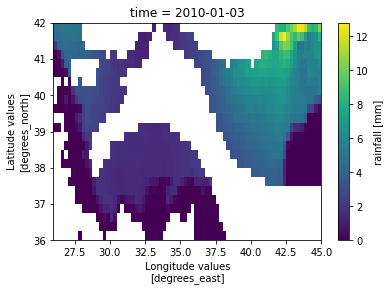

In [5]:
eobs_period_tr.isel(time=2).plot()

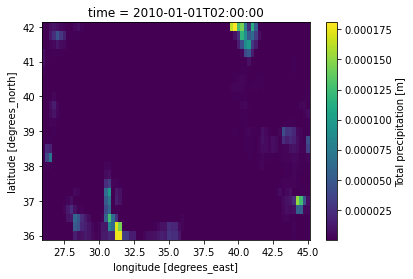

In [6]:
era5_period_tr.isel(time=2).plot()

Make sure that the ERA5 data is resampled to daily total precipitation values!

In [7]:
era5_period_tr = era5_period_tr.resample(time="1D").sum(dim='time') * 1000 # m to mm

In this analysis, it is not necessary that the utilized datasets include data values at grid points outside the boundaries of Turkey. We will be using a shapefile for the clip operation.

In [8]:
eobs_period_tr_shp = shape_.clip_turkey_shape(eobs_period_tr)
era5_period_tr_shp = shape_.clip_turkey_shape(era5_period_tr)

#### Match dataset's grids

We will reproject  $data$'s grids onto  $match\_data$'s and match them.

In [9]:
eobs_period_tr_shp_reprojected = proj_.reproject_match_rio(data=eobs_period_tr_shp, 
                                                   match_data=era5_period_tr_shp,
                                                   data_proj=proj_.basic_crs_info_2, 
                                                   match_data_proj=proj_.basic_crs_info_2)

Rioxarray's $reproject\_match$ method renames the latitude-longitude coordinates as y-x. Therefore, we better check again if the dimension names match.

In [10]:
# reprojection changes the name of the dims lat to y; lon to x
proj_.check_dim_consistency(eobs_period_tr_shp_reprojected, era5_period_tr_shp)

AssertionError: data dims do not match, consider matching

We get the error `data dims do not match, consider matching`. So let's match the dimension names again.

In [11]:
eobs_period_tr_shp_reprojected = proj_.match_latlon_dims(eobs_period_tr_shp_reprojected)

#### Transform continuous values into binary 

Contingency tables require using discrete ($2$-state or more) data values for the calculation of its statistics. Given that the retrieved datasets consist of continuous values (i.e., can take on any value within a given interval), a specific approach will be implemented to transform these continuous data points into $2$-state discrete values (binary). 

It is important to note that the method used in the creation of the binary data values will affect the corresponding contingency table statistics.

The method implemented in this analysis is as follows:
* Calculate the daily total precipitation climatology of the $E$-$Obs$ dataset
* Compute the daily anomalies for both $ERA5$ and $E$-$Obs$ datasets using the daily total precipitation climatology calculated with the $E$-$Obs$ data.
* If the data value at any particular day and grid is `less` ($negative$) than the corresponding anomaly: assign $0$
* Otherwise, if the data value at any particular day and grid is `larger` ($positive$) than the corresponding anomaly: assign $1$

$Note$: We assume that $E$-$Obs$ ($ERA5$) is the observation (forecast) dataset for the contingency table demonstration purposes.

In [12]:
eobs_period_daily_clim = eobs_period_tr_shp_reprojected.groupby("time.dayofyear").mean(dim='time') # daily climatology

# daily anomaly
era5_period_daily_anomaly = (era5_period_tr_shp.groupby("time.dayofyear") - eobs_period_daily_clim) 
eobs_period_daily_anomaly = (eobs_period_tr_shp_reprojected.groupby("time.dayofyear") - eobs_period_daily_clim) 

In [13]:
# Note that eobs_7910_daily_anomaly contains positive and negative values, where 
# the positive values should be transformed into the binary value of 1 
# (i.e., larger than the corresponding daily anomaly)

# for e-obs
era5_period_binary = era5_period_daily_anomaly.copy(deep=True) # copy for use
era5_period_binary.values = xr.where(era5_period_binary.values>0, 1, 0)

# for era5
eobs_period_binary = eobs_period_daily_anomaly.copy(deep=True) # copy for use
eobs_period_binary.values = xr.where(eobs_period_binary.values>0, 1, 0)

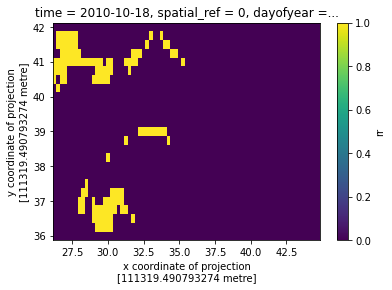

In [14]:
eobs_period_binary[290].plot()

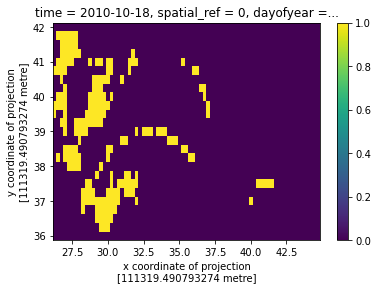

In [15]:
era5_period_binary[290].plot()

#### Create contingency table

Create a contingency table for a given latitude and longitude grid. As previously mentioned, the $ERA5$ precipitation data is assumed to be the forecast data for the calculation of the statistics.

Using the crosstab function of pandas library, we create the contingency table for the latitude of $41$ and longitude of $27$.

In [64]:
tab = pd.crosstab(index = era5_period_binary.sel(latitude=41, longitude=27),
                  columns = eobs_period_binary.sel(latitude=41, longitude=27),
                  dropna=False, rownames = ['Forecast'], colnames=['Obs']
              )

View the contingency table. Recall that

* Forecast(1) - Observation(1) = hits
* Forecast(1) - Observation(0) = false alarms
* Forecast(0) - Observation(1) = misses
* Forecast(0) - Observation(0) = correct negatives

In [65]:
tab

Obs,0,1
Forecast,,
0,2201,187
1,1163,467


In [96]:
hits = tab.loc[1][1]
false_alarms = tab.loc[1][0]
correct_neg = tab.loc[0][0]
misses = tab.loc[0][1]
total = tab.sum().sum()
hits_random = ((hits+misses)*(hits+false_alarms))/total

We use functions from the verification utils for the calculations of contingency table statistics. For a comprehensive explanation of these statistics, please refer to [this](https://www.cawcr.gov.au/projects/verification/#Contingency_table).

In [99]:
print(fr"Accuracy: {verif_.tab_accuracy(hits, correct_neg, total)}")
print(fr"Bias Score: {verif_.tab_bias_score(hits, false_alarms, misses)}")
print(fr"Probability of Detection: {verif_.tab_POD(hits, misses)}")
print(fr"False Alarm Ratio: {verif_.tab_FAR(hits, false_alarms)}")
print(fr"Probability of False Detection: {verif_.tab_POFD(correct_neg, false_alarms)}")
print(fr"Success Ratio: {verif_.tab_success_ratio(hits, false_alarms)}")
print(fr"Threat Score: {verif_.tab_threat_score(hits, misses, false_alarms)}")
print(fr"Equitable Threat Score: {verif_.tab_equitable_threat_score(hits, hits_random, misses, false_alarms)}")
print(fr"Hanssen and Kuipers discriminant: {verif_.tab_HK(hits, correct_neg, misses, false_alarms)}")

Accuracy: 0.664
Bias Score: 2.492
Probability of Detection: 0.714
False Alarm Ratio: 0.713
Probability of False Detection: 0.346
Success Ratio: 0.287
Threat Score: 0.257
Equitable Threat Score: 0.13
Hanssen and Kuipers discriminant: 0.368
